<a href="https://colab.research.google.com/github/random-words/colab-notebooks/blob/main/05__transfer_learning_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Creating Helper Functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-02-01 22:25:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-01 22:25:22 (50.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import neede functions from helper_functions file
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Data Preparation

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2025-02-01 22:25:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.207, 173.194.216.207, 74.125.26.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   184MB/s    in 0.9s    

2025-02-01 22:25:37 (184 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
unzip_data("10_food_classes_10_percent.zip")

In [7]:
# check directory information
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [8]:
# Create training and testing directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [9]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [12]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[237.94388    237.94388    203.94388   ]
   [237.71428    236.71428    205.71428   ]
   [237.71428    236.71428    205.92856   ]
   ...
   [254.         254.         254.        ]
   [254.         254.         254.        ]
   [254.         254.         254.        ]]

  [[238.92857    238.92857    204.92857   ]
   [237.9949     236.9949     205.9949    ]
   [236.92857    235.92857    205.14285   ]
   ...
   [254.         254.         254.        ]
   [254.         254.         254.        ]
   [254.         254.         254.        ]]

  [[237.86224    237.86224    203.86224   ]
   [237.         236.         205.        ]
   [236.21428    235.21428    204.42856   ]
   ...
   [254.         254.         254.        ]
   [254.         254.         254.        ]
   [254.         254.         254.        ]]

  ...

  [[213.71938    199.71938    160.71938   ]
   [216.71431    202.71431    163.71431   ]
   [216.42853    202.42853    163.52036   ]
   ...
   [232.55098    234.336

## Model 0 with Functional API

In [13]:
# create base model using tf.keras.applications
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)

# freeze base model, so weights aren't updated during training
base_model.trainable = False

# create inputs into model
inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,), name="input_layer")

# if using ResNet-like models, then need to normalize inputs
# x = tf.keras.layers.Rescaling(1/255.)(inputs)

# pass inputs through base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# average pool the outputs of base_model (aggregate all the most important information)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# create output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# combine inputs and outputs into model
model_0 = tf.keras.Model(inputs, outputs)

# compile model
model_0.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# fit model and save history
history_0 = model_0.fit(train_data_10_percent, epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extraction")])

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20250201-222542
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.2618 - loss: 2.1474 - val_accuracy: 0.7056 - val_loss: 1.3593
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.7541 - loss: 1.2651 - val_accuracy: 0.8026 - val_loss: 0.9023
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8178 - loss: 0.8893 - val_accuracy: 0.8372 - val_loss: 0.7042
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.8485 - loss: 0.7068 - val_accuracy: 0.8372 - val_loss: 0.6422
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8525 - loss: 0.6151 - val_accuracy: 0.8569 - val_loss: 0.5720


In [14]:
# Evaluate on full dataset
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8611 - loss: 0.5692


[0.5725693702697754, 0.8604000210762024]

In [15]:
# check layers
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [16]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, None, None, 16) │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, None, None, 16) │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, None, None, 16) │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, None, None, 64) │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, None, None, 64) │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, None, None, 64) │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, None, None, 32) │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, None, None, 32) │            128 │ block2a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [17]:
# our model summary
model_0.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

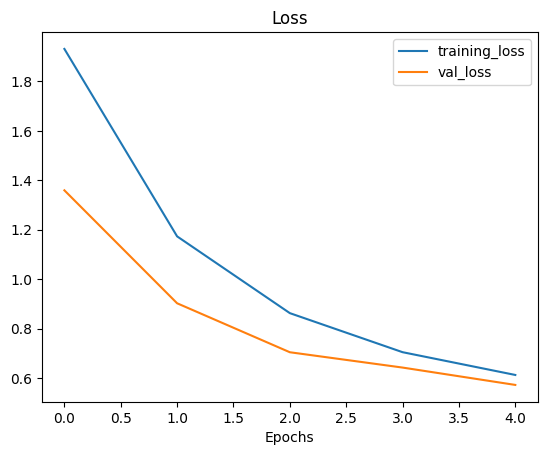

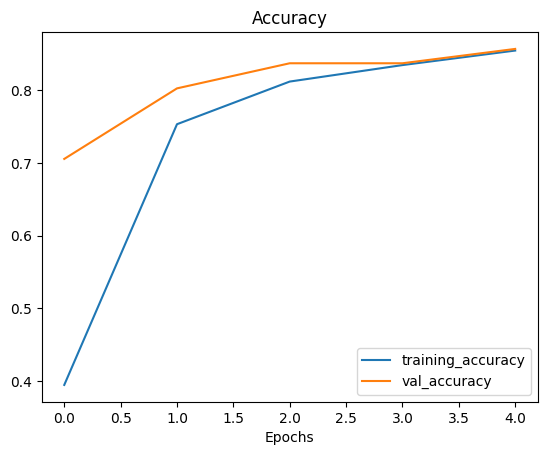

In [18]:
# Check loss curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

In [19]:
# Define input shape
input_shape = (1, 4, 4, 3)

# create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Input tensor:\n{input_tensor}")

Input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]


In [20]:
# Pass this tensor through GlobalAveragePooling2D
global_average_pool_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"tensor after pooling layer:\n{global_average_pool_tensor}")

tensor after pooling layer:
[[-0.09368646 -0.45840445 -0.28855976]]


In [21]:
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Global polling tensor shape: {global_average_pool_tensor.shape}")

Input tensor shape: (1, 4, 4, 3)
Global polling tensor shape: (1, 3)


In [22]:
# Replicating GlobalAveragePooling2D
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

In [23]:
# using MaxPool layer

# Define input shape
input_shape = (1, 4, 4, 3)

# create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Input tensor:\n{input_tensor}")

Input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]


In [24]:
# Pass this tensor through GlobalAveragePooling2D
global_max_pool_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"tensor after pooling layer:\n{global_max_pool_tensor}")

tensor after pooling layer:
[[0.9058464 1.1603122 1.6994323]]


In [25]:
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Global polling tensor shape: {global_max_pool_tensor.shape}")

Input tensor shape: (1, 4, 4, 3)
Global polling tensor shape: (1, 3)


In [26]:
# Replicating GlobalAveragePooling2D
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

# Running a series of transfer learning experiments

* Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
* Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
* Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.
* Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.

## Data Preprocessing

In [27]:
# Download 1% training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2025-02-01 22:37:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.207, 74.125.26.207, 108.177.11.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  46.3MB/s    in 2.8s    

2025-02-01 22:37:36 (46.3 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [28]:
unzip_data("10_food_classes_1_percent.zip")

In [29]:
# create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [30]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [31]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding Data Augmentation right into the model

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preprocessing

In [33]:
# Create data augmentation stage
data_augmentation = keras.Sequential([
    layers.Input((224, 224, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # layers.Rescaling(1/255.) # don't needed becaus EfficientNet already have rescaling
], name="data_augmentation")

### Visualizing data augmentation as a layer

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input [[[ 83.  70.  61.]
  [ 80.  67.  58.]
  [ 79.  66.  58.]
  ...
  [ 85.  38.  18.]
  [ 92.  41.  20.]
  [ 98.  46.  25.]]

 [[ 82.  68.  57.]
  [ 82.  69.  60.]
  [ 83.  69.  60.]
  ...
  [ 82.  35.  15.]
  [ 90.  39.  18.]
  [ 97.  45.  24.]]

 [[ 78.  62.  49.]
  [ 80.  66.  53.]
  [ 85.  68.  60.]
  ...
  [ 78.  30.  10.]
  [ 86.  35.  14.]
  [ 93.  41.  20.]]

 ...

 [[180. 187. 205.]
  [181. 188. 206.]
  [181. 188. 207.]
  ...
  [182. 190. 209.]
  [172. 183. 205.]
  [164. 175. 197.]]

 [[179. 186. 204.]
  [178. 185. 203.]
  [178. 185. 204.]
  ...
  [189. 189. 215.]
  [190. 189. 220.]
  [188. 187. 218.]]

 [[171. 178. 196.]
  [171. 178. 196.]
  [171. 178. 197.]
  ...
  [195. 190. 220.]
  [195. 189. 223.]
  [193. 187. 221.]]]. Expected shape (None, 224, 224, 3), but input has incompatible shape (512, 512, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(512, 512, 3), dtype=uint8)
  • training=None
  • mask=None

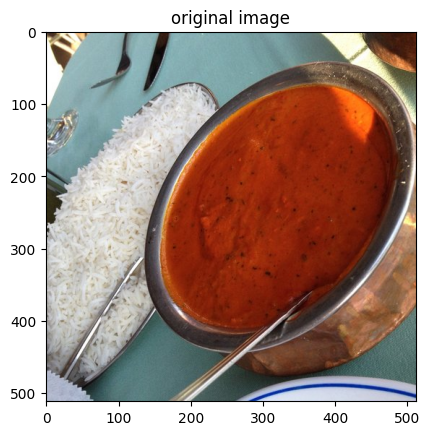

In [35]:
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# read random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title("original image")
# print(img)

# plot augmented image uising augmented model
augmented_img = data_augmentation(img)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255)
plt.title("augmented image")

* NOTE FOR LATER: якщо будуть погані результати моделі, то треба буде в аугментаційному слої домножити все на 255

## Model 1: Feature extraction on 1% of original data with data augmentation

🔑 **Note:** if it's a model - then *pass input or "x" into it* (base_model(x)), but if it's a layer - then *after creating an instance* (layers.GlobalAveragePooling2D()(x))

In [36]:
# Setup model
input_shape = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False # Freeze model patterns

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs after augmentation
x = base_model(x, training=False)

# Pool output features of the base_model into single feature(s) vector
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create a model_1
model_1 = keras.Model(inputs, outputs)

# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent, epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20250201-223802
Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 63s 22s/step - accuracy: 0.0897 - loss: 2.3832 - val_accuracy: 0.1316 - val_loss: 2.2912
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 82s 22s/step - accuracy: 0.2016 - loss: 2.2121 - val_accuracy: 0.2039 - val_loss: 2.1806
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 22s/step - accuracy: 0.3511 - loss: 2.0823 - val_accuracy: 0.2632 - val_loss: 2.0868
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 87s 25s/step - accuracy: 0.4181 - loss: 1.8883 - val_accuracy: 0.3273 - val_loss: 2.0094
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 78s 23s/step - accuracy: 0.5117 - loss: 1.8332 - val_accuracy: 0.4079 - val_loss: 1.9156


In [37]:
# Check summary
model_1.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, None, None, 1280)    │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,957,744 (22.73 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 25,622 (100.09 KB)

In [38]:
# Evaluate on full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.3875 - loss: 1.9318


[1.9232536554336548, 0.3912000060081482]

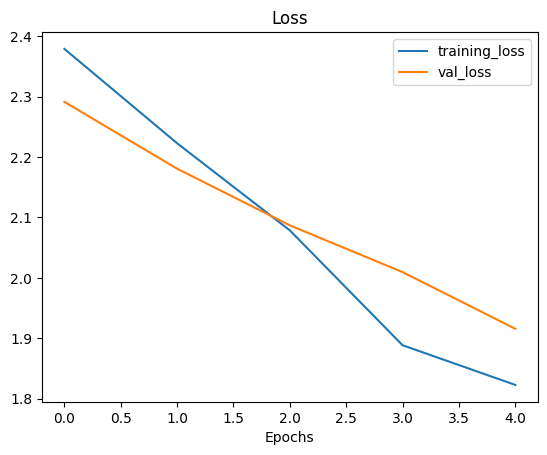

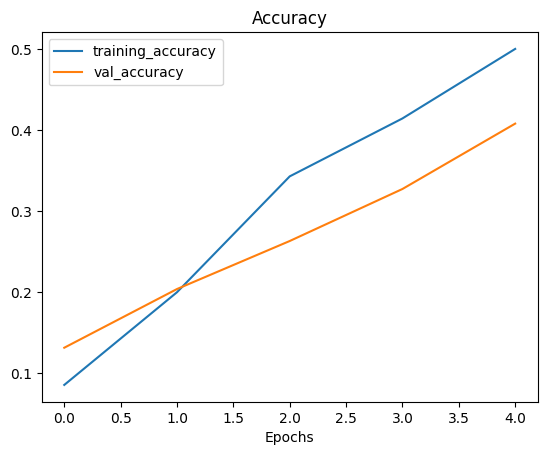

In [39]:
# Visualize loss/accuracy curves
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction on 10% of original data with data augmentation

In [40]:
# get 10% train data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

In [41]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [42]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [43]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [52]:
# Create model_2 and data_augmentation Sequential model layer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    # layers.Rescaling(1/255.) # dont needed for our model
], name="data_augmentation")

# Setup input shape
input_shape = IMG_SIZE + (3,)

# Create a froze base_model (this is also called "the backbone")
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create inputs and outputs and everything between them
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment data
x = base_model(x, training=False) # freeze weights (inference mode) and batchnorm layers stays the same too
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [45]:
model_2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, None, None, 1280)    │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_2D_layer      │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

### Creating a ModelCheckpoint callback

In [53]:
# Set checkpoint path
# (changet from ..../checkpoint.ckpt to ..../checkpoint.weights.h5 because of error)
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.weights.h5"

In [54]:
# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch",
                                                         verbose=1) # save every epoch

In [55]:
# Fit the model and use checkpoint callback
history_10_percent_data_aug = model_2.fit(train_data_10_percent, epochs=5,
#                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20250201-230618
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2176 - loss: 2.1950
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.2225 - loss: 2.1882 - val_accuracy: 0.5938 - val_loss: 1.5648
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6145 - loss: 1.5117
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.6153 - loss: 1.5087 - val_accuracy: 0.7681 - val_loss: 1.0990
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7279 - loss: 1.1593
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkpoint.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.7272 - loss: 1.1588 - val_accuracy: 0.7911 - val_loss: 0.8709
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7359 

In [49]:
model_0.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.8599 - loss: 0.5665


[0.5725693106651306, 0.8604000210762024]

In [50]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - categorical_accuracy: 0.8276 - loss: 0.6726


[0.6827154755592346, 0.8187999725341797]

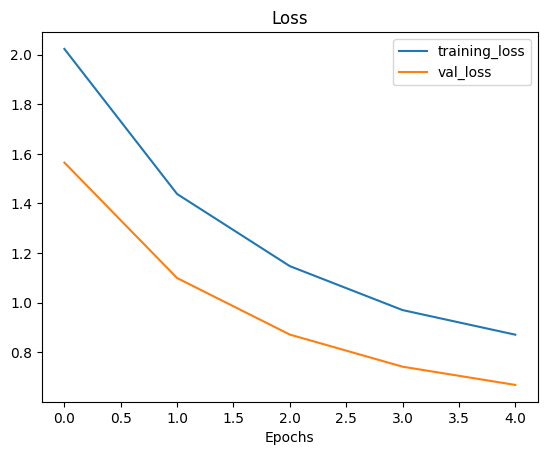

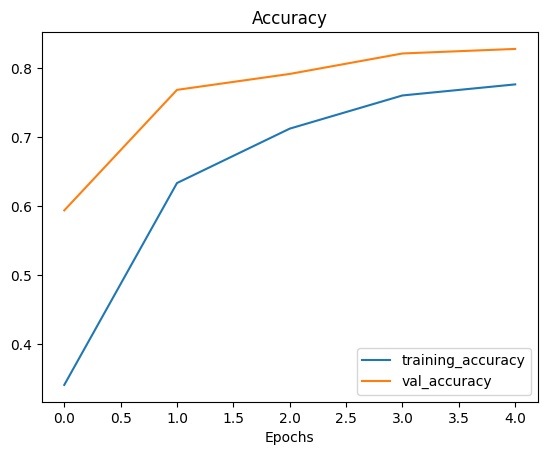

In [56]:
# Plot loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

In [57]:
model_2.load_weights(checkpoint_path)

In [58]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8210 - loss: 0.6847


In [59]:
results_10_percent_data_aug

[0.6827154755592346, 0.8187999725341797]

In [60]:
loaded_weights_model_results

[0.6802690029144287, 0.824400007724762]

In [61]:
# check is our loadedresults close to non-loaded results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([False, False])

In [62]:
# difference
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[ 0.00244647 -0.00560004]


## Model 3: Fine-tuning an existing model with 10% training data

In [63]:
# layers in model_2
model_2.layers

[<InputLayer name=input_layer, built=True>,
 <Sequential name=data_augmentation, built=True>,
 <Functional name=efficientnetv2-b0, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling_2D_layer, built=True>,
 <Dense name=output_layer, built=True>]

In [64]:
for layer in model_2.layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> True
<Sequential name=data_augmentation, built=True> True
<Functional name=efficientnetv2-b0, built=True> False
<GlobalAveragePooling2D name=global_average_pooling_2D_layer, built=True> True
<Dense name=output_layer, built=True> True


In [66]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_layer_5 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [67]:
# trainable variable quantity
print(len(model_2.layers[2].trainable_variables))

0


In [68]:
# set last 10 layers of base_model.trainable = True
base_model.trainable = True

# Freeze all layers except of last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile model every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001), # when fine-tuning you typically want to lower learning rate by 10x
                metrics=["accuracy"])

* When fine-tuning you typically want to lower learning rate because pre-trained modelalready have weights and you don't want to overfit them using your data. As general baseline, you want to lower learning rate by 10x (Adam(0.001) -> Adam(0.0001))

In [69]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_5 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [72]:
# trainable variable quantity
print(len(model_2.trainable_variables))

12


In [73]:
model_2.trainable_variables

[<Variable path=block6h_se_reduce/kernel, shape=(1, 1, 1152, 48), dtype=float32, value=[[[[-0.00207604  0.01300672  0.02047416 ... -0.02240255 -0.07708141
     -0.00094655]
    [-0.06357138  0.0959678  -0.05430871 ... -0.01352078 -0.05987524
     -0.11093444]
    [ 0.0068749  -0.04681807 -0.01513974 ...  0.03073284 -0.01280731
      0.03616464]
    ...
    [ 0.11381665  0.00804447 -0.05432149 ...  0.08015257 -0.06561387
     -0.05522665]
    [-0.12468243  0.06938899 -0.07634895 ...  0.01121222 -0.0128268
      0.10406019]
    [-0.04722364  0.10557885  0.16247186 ...  0.04582691  0.01228108
     -0.04941604]]]]>,
 <Variable path=block6h_se_reduce/bias, shape=(48,), dtype=float32, value=[ 0.04594925  2.5461788  -1.426646   -0.7885664  -0.24730209 -0.5630991
  -0.6161863  -0.4029834  -1.4444699  -1.0481553  -0.21704195 -0.64428073
  -1.0262699   0.51246476 -1.1002927  -0.57510656 -0.4755902   0.78507984
  -0.21726058 -0.8636311  -0.5850221  -0.6715491  -0.8322267   0.26295963
  -1.1431009

In [74]:
initial_epochs = 5

In [75]:
# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (model_2 but more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20250202-001349
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 123s 4s/step - accuracy: 0.7532 - loss: 1.0042 - val_accuracy: 0.8191 - val_loss: 0.7293
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.7556 - loss: 0.9143 - val_accuracy: 0.8322 - val_loss: 0.6598
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - accuracy: 0.7870 - loss: 0.8627 - val_accuracy: 0.8487 - val_loss: 0.6020
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8237 - loss: 0.7715 - val_accuracy: 0.8520 - val_loss: 0.5524
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.8185 - loss: 0.7420 - val_accuracy: 0.8586 - val_loss: 0.4952
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - accuracy: 0.8537 - loss: 0.6609 - val_accuracy: 0.8487 - val_loss: 0.5138


In [76]:
# Evaluate fine-tuned model
results_fine_tuned_10_percent = model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.8519 - loss: 0.5067


In [77]:
results_10_percent_data_aug

[0.6827154755592346, 0.8187999725341797]

In [78]:
results_fine_tuned_10_percent

[0.5126789212226868, 0.8515999913215637]

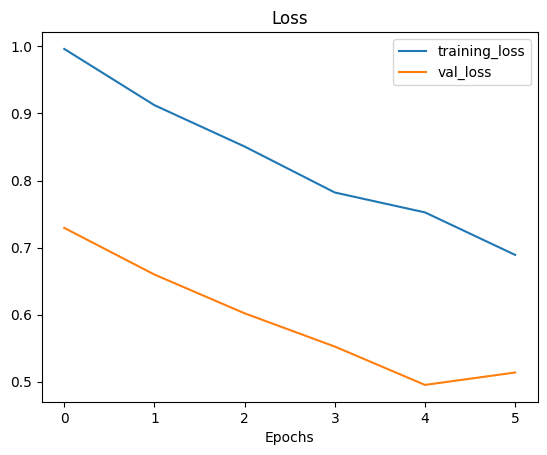

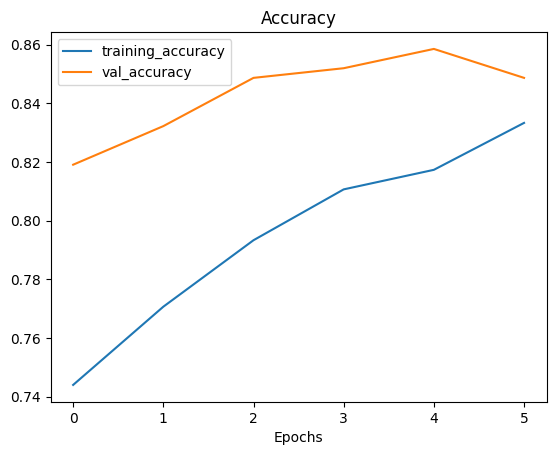

In [80]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [88]:
# Create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  # Get original history
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = acc + new_history.history["val_accuracy"]
  total_val_loss = loss + new_history.history["val_loss"]

  # Make plot for Accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine-tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plot for Loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start fine-tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

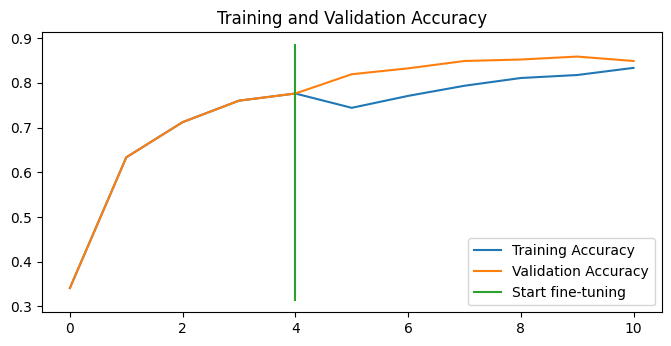

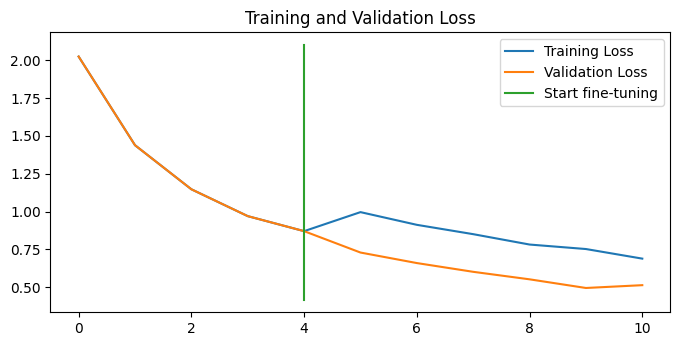

In [89]:
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data

In [90]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2025-02-02 00:56:52--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.207, 74.125.134.207, 74.125.139.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  53.0MB/s    in 10s     

2025-02-02 00:57:02 (49.6 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [91]:
# Setup directories
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [93]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [94]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE,
                                                                                 batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [99]:
test_data.as_numpy_iterator().next()

(array([[[[1.19586739e+02, 6.15867348e+01, 4.75867348e+01],
          [1.20051018e+02, 6.26479607e+01, 4.68571434e+01],
          [1.20209183e+02, 6.49285736e+01, 4.57704086e+01],
          ...,
          [1.97091827e+02, 1.87464233e+02, 1.73173386e+02],
          [1.96668274e+02, 1.82668274e+02, 1.69668274e+02],
          [1.83596832e+02, 1.67596832e+02, 1.54596832e+02]],
 
         [[1.19020409e+02, 6.30204086e+01, 4.60204086e+01],
          [1.26367348e+02, 7.12295914e+01, 5.16428604e+01],
          [1.19913269e+02, 6.55561295e+01, 4.44132690e+01],
          ...,
          [1.97780533e+02, 1.89209061e+02, 1.73994797e+02],
          [1.94056046e+02, 1.80056046e+02, 1.67056046e+02],
          [1.84806015e+02, 1.68806015e+02, 1.55806015e+02]],
 
         [[1.21209183e+02, 6.96377563e+01, 4.74285698e+01],
          [1.20403061e+02, 6.88316345e+01, 4.61887741e+01],
          [1.21903061e+02, 7.02857132e+01, 4.56428604e+01],
          ...,
          [1.95596878e+02, 1.87025406e+02, 1.7181

* To fine-tune model_4, we need to revert back model_2 to its feature extraction weights. To do so, we need to load weights from checkpoint

In [101]:
# Load weights from checkpoint
model_2.load_weights(checkpoint_path)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [102]:
# Evaluating feature extraction model_2
model_2.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8295 - loss: 0.6945


[0.6802688837051392, 0.824400007724762]

In [106]:
results_10_percent_data_aug

[0.6827154755592346, 0.8187999725341797]

In [107]:
results_fine_tuned_10_percent

[0.5126789212226868, 0.8515999913215637]

In [108]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 True
3 global_average_pooling_2D_layer True
4 output_layer True


In [109]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_5 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dw

In [110]:
# Recompile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001), # lower learning rate because of fine-tuning
                metrics=["accuracy"])

In [112]:
# Fit on 100% of the data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                  "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20250202-013326
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 684s 3s/step - accuracy: 0.7292 - loss: 1.0046 - val_accuracy: 0.8750 - val_loss: 0.4539
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 681s 3s/step - accuracy: 0.7840 - loss: 0.7441 - val_accuracy: 0.8964 - val_loss: 0.3531
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 637s 3s/step - accuracy: 0.8067 - loss: 0.6587 - val_accuracy: 0.8931 - val_loss: 0.3394
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 626s 3s/step - accuracy: 0.8213 - loss: 0.6043 - val_accuracy: 0.9062 - val_loss: 0.2871
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step - accuracy: 0.8265 - loss: 0.5652 - val_accuracy: 0.9095 - val_loss: 0.2852
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 674s 3s/step - accuracy: 0.8334 - loss: 0.5501 - val_accuracy: 0.9079 - val_loss: 0.2691


In [113]:
# Evaluating on all of the data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9138 - loss: 0.2541


[0.25333645939826965, 0.9132000207901001]

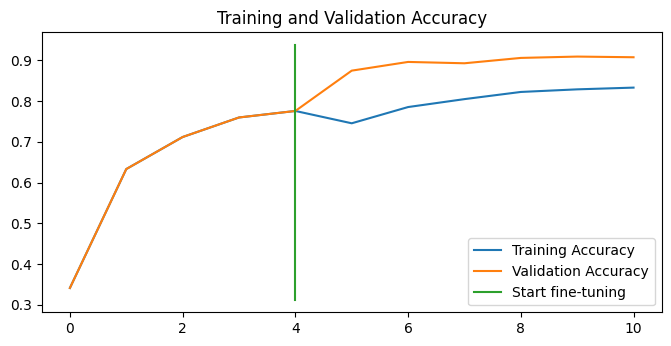

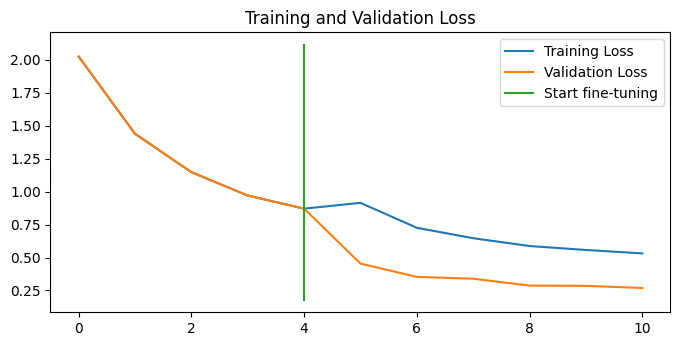

In [114]:
compare_histories(original_history=history_10_percent_data_aug,
                  new_history=history_fine_10_classes_full,
                  initial_epochs=5)